#Proyecto Procesamiento de Datos a Gran Escala
## Realizado por:
* Andres Felipe Galan Cardenas
* Diego Alejandro Martínez Oviedo
* Julian Andrey Mendez Rodriguez
* Samuel Andres Lamilla Verjan
* Steven Viscillinovick Robles Patiño

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Proyecto ICFES Cundinamarca") \
    .getOrCreate()

ruta_archivo = "/content/base_reducida.csv"
kmeans_archivo = "/content/base_con_clusters.csv"
df = spark.read.csv(ruta_archivo, header=True, inferSchema=True)
df_kmeans = spark.read.csv(kmeans_archivo, header=True, inferSchema=True)

df = df.withColumnRenamed("No. ACCESOS FIJOS A INTERNET", "ACCESOS_FIJOS_INTERNET")
df_kmeans= df_kmeans.withColumnRenamed("No. ACCESOS FIJOS A INTERNET", "ACCESOS_FIJOS_INTERNET")
df.show(5)
df.printSchema()
df_kmeans.printSchema()
df_kmeans.show(5)

+-------+------------+---------+------------------------+-----+---------------+---------------+-------------+------------+----------------------+----------+--------------+---------+-----------+----------+--------------+
|PERIODO|DEPARTAMENTO|Municipio|CODIGO PLANTEL EDUCATIVO|GRADO|TOTAL INSCRITOS|TOTAL EVALUADOS|CLASIFICACION|INDICE TOTAL|ACCESOS_FIJOS_INTERNET|APROBACIÓN|POBLACIÓN DANE|DESERCIÓN|REPROBACIÓN|REPITENCIA|COBERTURA_NETA|
+-------+------------+---------+------------------------+-----+---------------+---------------+-------------+------------+----------------------+----------+--------------+---------+-----------+----------+--------------+
|   2021|   antioquia|  granada|            105313000016| 11.0|          271.0|          267.0|            B|        0.67|                  1884|     91.22|         29451|     3.89|       4.89|      3.86|         90.62|
|   2021|   antioquia|  granada|            205313000215| 11.0|           13.0|           12.0|            D|        0.5

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Variables categóricas
categorical_cols = ["DEPARTAMENTO", "Municipio", "CLASIFICACION"]

# Variables numéricas
numeric_cols = [
    "PERIODO", "GRADO", "TOTAL INSCRITOS", "TOTAL EVALUADOS",
    "ACCESOS_FIJOS_INTERNET", "APROBACIÓN",
    "POBLACIÓN DANE", "DESERCIÓN", "REPROBACIÓN",
    "REPITENCIA", "COBERTURA_NETA"
]

# Paso 1: Indexación
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec") for col in categorical_cols]

# Paso 2: Ensamblar las columnas numéricas y categóricas
feature_cols = [col + "_vec" for col in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Paso 3: Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(df)
df_preparado = pipeline_model.transform(df)

# Resultado
df_preparado.select("features", "INDICE TOTAL").show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                    |INDICE TOTAL|
+--------------------------------------------------------------------------------------------------------------------------------------------+------------+
|(136,[1,18,121,125,126,127,128,129,130,131,132,133,134,135],[1.0,1.0,1.0,2021.0,11.0,271.0,267.0,1884.0,91.22,29451.0,3.89,4.89,3.86,90.62])|0.67        |
|(136,[1,18,120,125,126,127,128,129,130,131,132,133,134,135],[1.0,1.0,1.0,2021.0,11.0,13.0,12.0,1884.0,91.22,29451.0,3.89,4.89,3.86,90.62])  |0.58        |
|(136,[1,18,122,125,126,127,128,129,130,131,132,133,134,135],[1.0,1.0,1.0,2021.0,11.0,30.0,30.0,1884.0,91.22,29451.0,3.89,4.89,3.86,90.62])  |0.65        |
|(136,[1,26,122,125,126,127,128,129,130,131,132,133,134,135],[1.

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Paso 1: Dividir en entrenamiento (70%) y prueba (30%)
datos_entrenamiento, datos_prueba = df_preparado.randomSplit([0.7, 0.3], seed=42)

# Paso 2: Crear y entrenar el modelo de Random Forest
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="INDICE TOTAL",
    predictionCol="prediccion",
    numTrees=100,
    maxDepth=5,
    seed=42
)

modelo_rf = rf.fit(datos_entrenamiento)

# Paso 3: Hacer predicciones sobre los datos de prueba
predicciones = modelo_rf.transform(datos_prueba)

# Paso 4: Evaluar el modelo
evaluator_rmse = RegressionEvaluator(
    labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="rmse"
)
evaluator_mae = RegressionEvaluator(
    labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="mae"
)
evaluator_mse = RegressionEvaluator(
    labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="mse"
)
evaluator_r2 = RegressionEvaluator(
    labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="r2"
)

# Resultados
rmse = evaluator_rmse.evaluate(predicciones)
mae = evaluator_mae.evaluate(predicciones)
mse = evaluator_mse.evaluate(predicciones)
r2 = evaluator_r2.evaluate(predicciones)

# Imprimir resultados
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


RMSE: 0.0303
MAE: 0.0224
MSE: 0.0009
R²: 0.8372


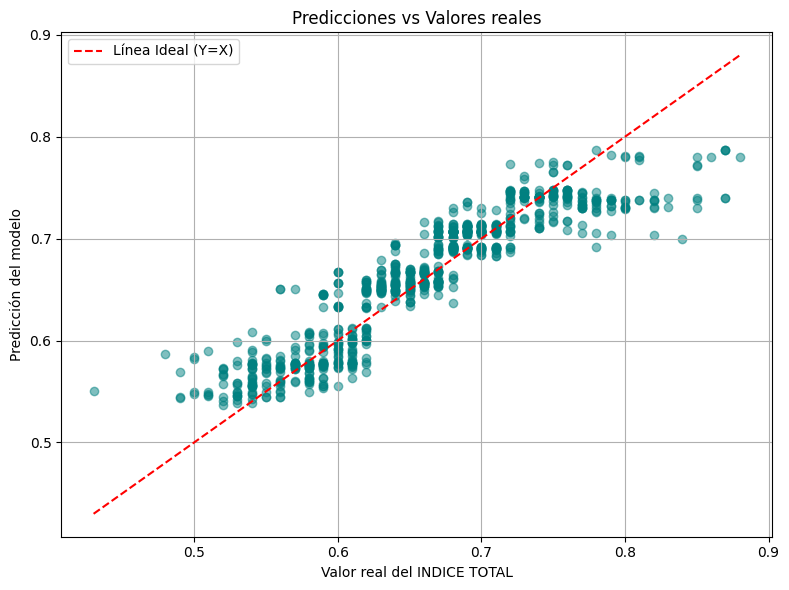

In [ ]:
import matplotlib.pyplot as plt

# Convertir a pandas para graficar
preds = predicciones.select("INDICE TOTAL", "prediccion").toPandas()

# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(preds["INDICE TOTAL"], preds["prediccion"], alpha=0.5, color='teal')
plt.plot([preds["INDICE TOTAL"].min(), preds["INDICE TOTAL"].max()],
         [preds["INDICE TOTAL"].min(), preds["INDICE TOTAL"].max()],
         color='red', linestyle='--', label="Línea Ideal (Y=X)")

plt.title("Predicciones vs Valores reales")
plt.xlabel("Valor real del INDICE TOTAL")
plt.ylabel("Predicción del modelo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


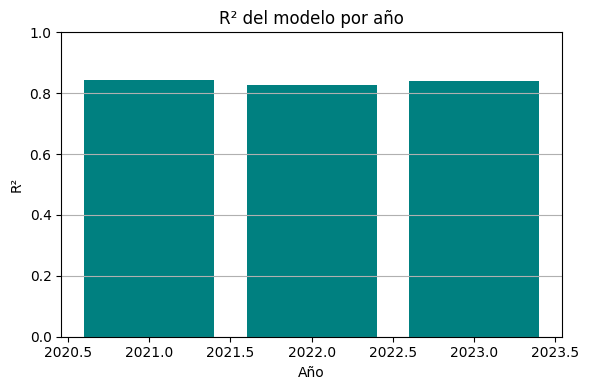

In [ ]:
from pyspark.sql.functions import col

r2_por_anio = {}

# Evaluador
evaluator_r2 = RegressionEvaluator(labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="r2")

# Iterar por cada año
for anio in [2021, 2022, 2023]:
    df_anio = predicciones.filter(col("PERIODO") == anio)
    r2 = evaluator_r2.evaluate(df_anio)
    r2_por_anio[anio] = r2

# Gráfico
df_r2_anio = pd.DataFrame(list(r2_por_anio.items()), columns=["Año", "R2"])

plt.figure(figsize=(6, 4))
plt.bar(df_r2_anio["Año"], df_r2_anio["R2"], color="teal")
plt.title("R² del modelo por año")
plt.xlabel("Año")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


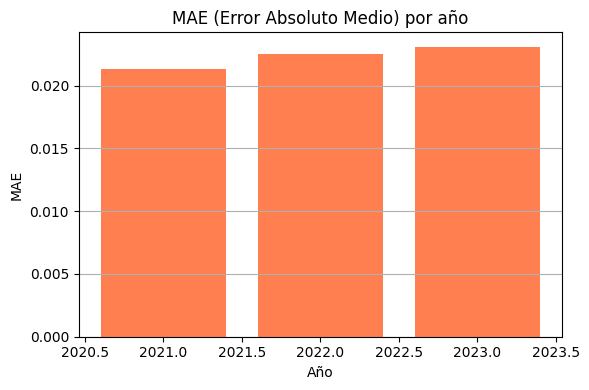

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

mae_por_anio = {}
evaluator_mae = RegressionEvaluator(labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="mae")

for anio in [2021, 2022, 2023]:
    df_anio = predicciones.filter(col("PERIODO") == anio)
    mae = evaluator_mae.evaluate(df_anio)
    mae_por_anio[anio] = mae

# Gráfico
df_mae_anio = pd.DataFrame(list(mae_por_anio.items()), columns=["Año", "MAE"])

plt.figure(figsize=(6, 4))
plt.bar(df_mae_anio["Año"], df_mae_anio["MAE"], color="coral")
plt.title("MAE (Error Absoluto Medio) por año")
plt.xlabel("Año")
plt.ylabel("MAE")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


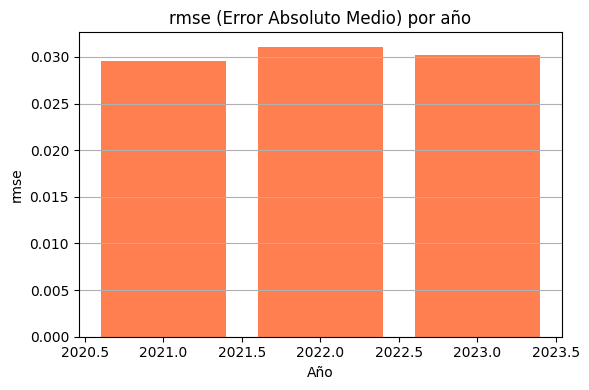

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_por_anio = {}
evaluator_rmse  = RegressionEvaluator(labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="rmse")

for anio in [2021, 2022, 2023]:
    df_anio = predicciones.filter(col("PERIODO") == anio)
    rmse = evaluator_rmse.evaluate(df_anio)
    rmse_por_anio[anio] = rmse

# Gráfico
df_rmse_anio = pd.DataFrame(list(rmse_por_anio.items()), columns=["Año", "rmse"])

plt.figure(figsize=(6, 4))
plt.bar(df_rmse_anio["Año"], df_rmse_anio["rmse"], color="coral")
plt.title("rmse (Error Absoluto Medio) por año")
plt.xlabel("Año")
plt.ylabel("rmse")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [ ]:
# Agregamos 'Cluster'
categorical_cols_k = ["DEPARTAMENTO", "Municipio", "CLASIFICACION", "Cluster"]

numeric_cols_k = [
    "PERIODO", "GRADO", "TOTAL INSCRITOS", "TOTAL EVALUADOS",
    "ACCESOS_FIJOS_INTERNET", "APROBACIÓN",
    "POBLACIÓN DANE", "DESERCIÓN", "REPROBACIÓN",
    "REPITENCIA", "COBERTURA_NETA"
]


from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

indexers_k = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols_k]
encoders_k = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec") for col in categorical_cols_k]


feature_cols_k = [col + "_vec" for col in categorical_cols_k] + numeric_cols_k
assembler_k = VectorAssembler(inputCols=feature_cols_k, outputCol="features")


pipeline_k = Pipeline(stages=indexers_k + encoders_k + [assembler_k])
pipeline_model_k = pipeline_k.fit(df_kmeans)
df_preparado_k = pipeline_model_k.transform(df_kmeans)


In [ ]:
datos_entrenamiento_k, datos_prueba_k = df_preparado_k.randomSplit([0.7, 0.3], seed=55)


rf_k = RandomForestRegressor(
    featuresCol="features",
    labelCol="INDICE TOTAL",
    predictionCol="prediccion",
    numTrees=100,
    maxDepth=5,
    seed=42
)

modelo_rf_k = rf_k.fit(datos_entrenamiento_k)


predicciones_k = modelo_rf_k.transform(datos_prueba_k)


evaluator_rmse_k = RegressionEvaluator(
    labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="rmse"
)
evaluator_mae_k = RegressionEvaluator(
    labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="mae"
)
evaluator_mse_k = RegressionEvaluator(
    labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="mse"
)
evaluator_r2_k = RegressionEvaluator(
    labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="r2"
)


rmse_k = evaluator_rmse_k.evaluate(predicciones_k)
mae_k = evaluator_mae_k.evaluate(predicciones_k)
mse_k = evaluator_mse_k.evaluate(predicciones_k)
r2_k = evaluator_r2_k.evaluate(predicciones_k)


print(f"RMSE: {rmse_k:.4f}")
print(f"MAE: {mae_k:.4f}")
print(f"MSE: {mse_k:.4f}")
print(f"R²: {r2_k:.4f}")


RMSE: 0.0330
MAE: 0.0236
MSE: 0.0011
R²: 0.8220


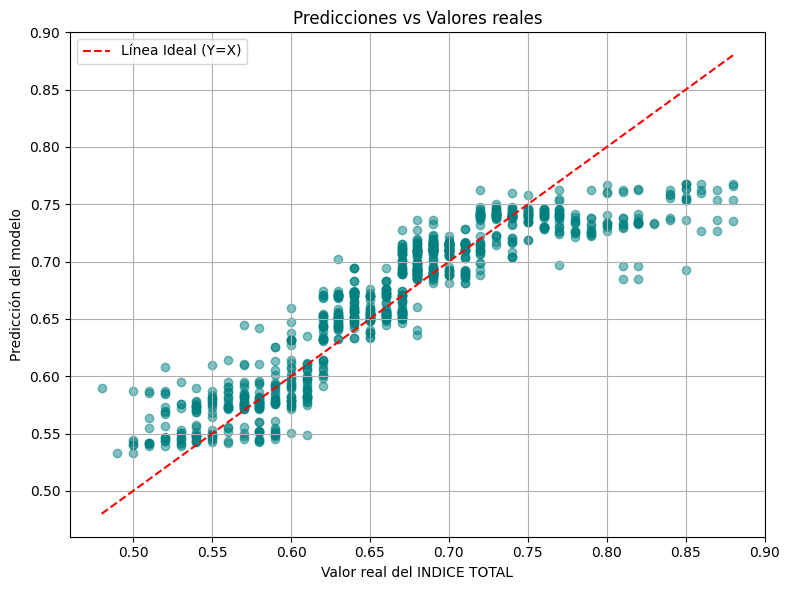

In [ ]:
# Convertir a pandas para graficar
preds_k = predicciones_k.select("INDICE TOTAL", "prediccion").toPandas()

# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(preds_k["INDICE TOTAL"], preds_k["prediccion"], alpha=0.5, color='teal')
plt.plot([preds_k["INDICE TOTAL"].min(), preds_k["INDICE TOTAL"].max()],
         [preds_k["INDICE TOTAL"].min(), preds_k["INDICE TOTAL"].max()],
         color='red', linestyle='--', label="Línea Ideal (Y=X)")

plt.title("Predicciones vs Valores reales")
plt.xlabel("Valor real del INDICE TOTAL")
plt.ylabel("Predicción del modelo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

def entrenar_y_evaluar(df, incluir_cluster=True):

    cat_cols = ["DEPARTAMENTO", "Municipio", "CLASIFICACION"]
    if incluir_cluster:
        cat_cols.append("Cluster")

    num_cols = [
        "PERIODO", "GRADO", "TOTAL INSCRITOS", "TOTAL EVALUADOS",
        "ACCESOS_FIJOS_INTERNET", "APROBACIÓN", "POBLACIÓN DANE",
        "DESERCIÓN", "REPROBACIÓN", "REPITENCIA", "COBERTURA_NETA"
    ]


    indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in cat_cols]
    encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec") for col in cat_cols]
    features = [col+"_vec" for col in cat_cols] + num_cols
    assembler = VectorAssembler(inputCols=features, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    model_pipeline = pipeline.fit(df)
    df_prep = model_pipeline.transform(df)


    train_data, test_data = df_prep.randomSplit([0.7, 0.3], seed=42)


    rf = RandomForestRegressor(
        featuresCol="features", labelCol="INDICE TOTAL",
        predictionCol="prediccion", numTrees=100, maxDepth=5, seed=42
    )
    modelo_rf = rf.fit(train_data)
    predicciones = modelo_rf.transform(test_data)


    evaluadores = {
        "RMSE": RegressionEvaluator(labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="rmse"),
        "MAE": RegressionEvaluator(labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="mae"),
        "R2": RegressionEvaluator(labelCol="INDICE TOTAL", predictionCol="prediccion", metricName="r2")
    }

    resultados = {nombre: evaluator.evaluate(predicciones) for nombre, evaluator in evaluadores.items()}
    return resultados


In [ ]:
# Sin cluster
resultados_sin_cluster = entrenar_y_evaluar(df, incluir_cluster=False)
print("Modelo SIN Cluster:")
for k, v in resultados_sin_cluster.items():
    print(f"{k}: {v:.4f}")

# Con cluster
resultados_con_cluster = entrenar_y_evaluar(df_kmeans, incluir_cluster=True)
print("\nModelo CON Cluster:")
for k, v in resultados_con_cluster.items():
    print(f"{k}: {v:.4f}")


Modelo SIN Cluster:
RMSE: 0.0303
MAE: 0.0224
R2: 0.8372

Modelo CON Cluster:
RMSE: 0.0309
MAE: 0.0229
R2: 0.8309


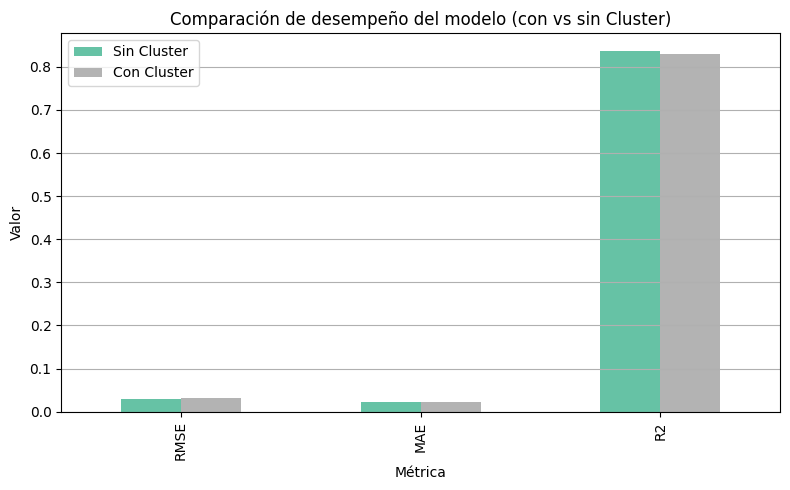

In [ ]:
df_comparacion = pd.DataFrame({
    "Métrica": ["RMSE", "MAE", "R2"],
    "Sin Cluster": [resultados_sin_cluster["RMSE"], resultados_sin_cluster["MAE"], resultados_sin_cluster["R2"]],
    "Con Cluster": [resultados_con_cluster["RMSE"], resultados_con_cluster["MAE"], resultados_con_cluster["R2"]]
})
# Gráfico
df_comparacion.set_index("Métrica").plot(kind="bar", figsize=(8,5), colormap="Set2")
plt.title("Comparación de desempeño del modelo (con vs sin Cluster)")
plt.ylabel("Valor")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# ***¿Cómo aporta esto al objetivo?***

1. Identificación de factores determinantes: El modelo revela qué variables tienen mayor peso en la predicción del rendimiento académico, permitiendo enfocar las acciones estratégicas en los factores más influyentes (por ejemplo, mejorar la conectividad o reducir la deserción).

2. Priorización territorial: Al aplicar el modelo por municipio, es posible detectar zonas con bajo índice ICFES asociado a bajos niveles en las variables clave, lo cual permite focalizar la intervención institucional.

3. Simulación de escenarios: Este modelo puede utilizarse para simular cómo cambiaría el desempeño académico si se mejoran ciertos factores, por ejemplo, aumentar la cobertura o reducir la repitencia.